# Analyze Our Default Simulations

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [2]:
import importlib
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)

<module 'fates_calibration_library.analysis_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/analysis_functions.py'>

In [3]:
import importlib
import fates_calibration_library.ilamb_functions
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.ilamb_functions)
importlib.reload(fates_calibration_library.analysis_functions)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import matplotlib

In [4]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44969 instead
  warnings.warn(


In [5]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44969/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44969/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.187:38455,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44969/status,Total threads: 0
Started: 2 minutes ago,Total memory: 0 B


## Set Up

First specify history variables and variables to investigate

In [6]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QSOIL', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'RH2M', 'SNOW', 'RAIN', 'FGR12',
             'TREFMXAV', 'TREFMNAV']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'QSOIL', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS', 'FGR12',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA','RH2M', 'SNOW', 'RAIN',
           'TREFMXAV', 'TREFMNAV', 'RH2M']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSDS', 'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV', 'Temp',
            'RH2M', 'Precip']

### Files Needed

In [7]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')


# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

# ilamb observations
ilamb_config_file = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

## Read in Datasets

In [8]:
# FATES run with GSWP3
fates_gswp3_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai_default_latest/lnd/hist'
fates_gswp3 = analysis.post_process_ds(fates_gswp3_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

In [9]:
# FATES sparse grid run - latest tag
fates_crujra_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_crujra/lnd/hist'
fates_crujra = analysis.post_process_ds(fates_crujra_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [104]:
# annual means
fates_gswp3_annmeans = analysis.apply_to_vars(fates_gswp3, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

fates_crujra_annmeans = analysis.apply_to_vars(fates_crujra, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

In [105]:
# fates_gswp3_annmeans['ASA'] = fates_gswp3_annmeans['FSR']/fates_gswp3_annmeans['FSDS']
# fates_crujra_annmeans['ASA'] = fates_crujra_annmeans['FSR']/fates_crujra_annmeans['FSDS']

# fates_gswp3_annmeans['EF'] = fates_gswp3_annmeans['EFLX_LH_TOT']/(fates_gswp3_annmeans['EFLX_LH_TOT'] + fates_gswp3_annmeans['FSH'])
# fates_crujra_annmeans['EF'] = fates_crujra_annmeans['EFLX_LH_TOT']/(fates_crujra_annmeans['EFLX_LH_TOT']+ fates_gswp3_annmeans['FSH'])

In [106]:
fates_gswp3_annmeans = fates_gswp3_annmeans.mean(dim='year')
fates_crujra_annmeans = fates_crujra_annmeans.mean(dim='year')

In [107]:
# monthly means
fates_gswp3_monthmeans = analysis.apply_to_vars(fates_gswp3, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

fates_crujra_monthmeans = analysis.apply_to_vars(fates_crujra, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [108]:
# maps from the annual means
fates_glob_gswp3 = analysis.get_sparse_maps(fates_gswp3_annmeans, sparse_grid, out_vars)

fates_glob_crujra = analysis.get_sparse_maps(fates_crujra_annmeans, sparse_grid, out_vars)

In [109]:
fates_monthmax_gswp3 = analysis.apply_to_vars(fates_gswp3_monthmeans, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=True)
fates_monthmax_crujra = analysis.apply_to_vars(fates_crujra_monthmeans, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=True)

fates_monthmax_gswp3_glob = analysis.get_sparse_maps(fates_monthmax_gswp3, sparse_grid,
                                     out_vars)

fates_monthmax_crujra_glob = analysis.get_sparse_maps(fates_monthmax_crujra, sparse_grid,
                                     out_vars)

### Zonal Means
Calculate zonal means (by latitude)

In [110]:
# zonal means
fates_zonal_gswp3 = analysis.apply_to_vars(fates_glob_gswp3, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

fates_zonal_crujra = analysis.apply_to_vars(fates_glob_crujra, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

### Climatology
Calculate climatology

In [111]:
# area means from monthly
fates_clim_gswp3 = analysis.get_sparse_area_means(fates_gswp3_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_gswp3.biome)

fates_clim_crujra = analysis.get_sparse_area_means(fates_crujra_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_crujra.biome)

### Calculate Global Annual Values

Area-weighted averages

In [112]:
# sparse area means
fates_areameans_gswp3 = analysis.get_sparse_area_means(fates_gswp3_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_gswp3.biome)

fates_areameans_crujra = analysis.get_sparse_area_means(fates_crujra_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_crujra.biome)

## CRU-JRA vs. GSWP3
### Annual Maps

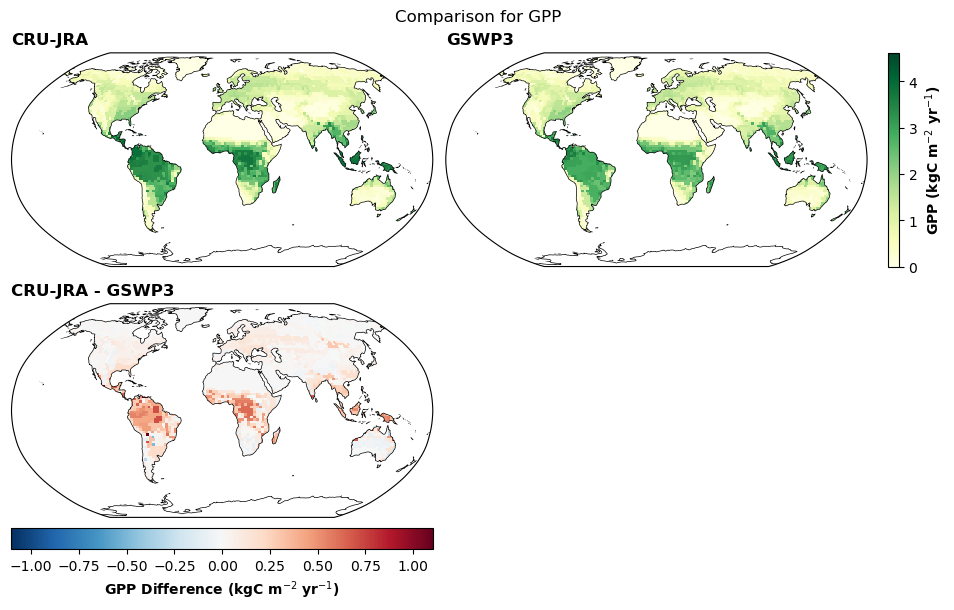

In [113]:
var = 'GPP'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'FSH'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EF'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'ASA'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'SOILWATER_10CM'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'BTRANMN'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

### Zonal Means

In [ ]:
var_name = 'GPP'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'ASA'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'FSH'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EF'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'SOILWATER_10CM'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

In [ ]:
var_name = 'BTRANMN'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

### Climatology

In [ ]:
var = 'GPP'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'FSH'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'EF'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'ASA'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'SOILWATER_10CM'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

In [ ]:
var = 'BTRANMN'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

### Global Annual Values

In [ ]:
summary_df = plotting.summarize_differences(fates_areameans_gswp3, fates_areameans_crujra,
                                            'GSWP3', 'CRU-JRA', var_dict)

In [ ]:
plotting.plot_heatmap(summary_df)

## Observational Comparisons
### Annual Maps

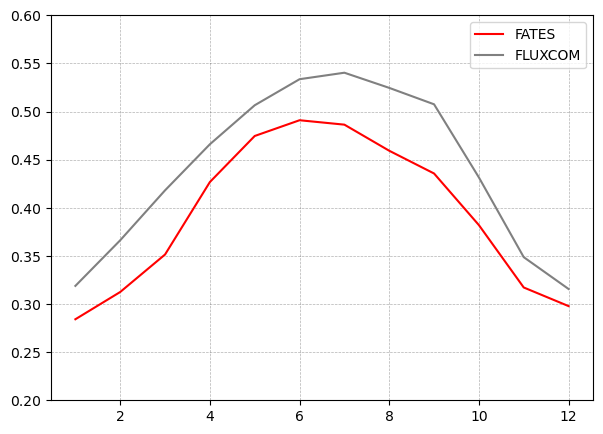

In [125]:
ilamb_clim = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var]['var']}_cycle",
                                ilamb_config[var]['models']).sel(model=model)
plt.figure(figsize=(7, 5))
ax = plt.subplot(111)
plt.plot(fates_clim_crujra.month, fates_clim_crujra[var], label='FATES', c='red')
plt.plot(ilamb_clim.month, ilamb_clim, label=model,c='gray')
plt.grid(
    True,
    which="both",
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="black",
    alpha=0.3,
)
plt.ylim(0.2, 0.6)
plt.legend()

In [ ]:
var = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'LAI'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(fates_glob_gswp3, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

### Zonal Means

In [ ]:
var_name = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'LAI'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

In [ ]:
var_name = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var_name]['var'], ilamb_config[var_name]['models'])
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area, ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var]['global_units'])

### Climatology

In [ ]:
var_name = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

In [ ]:
var_name = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_gswp3[var_name], var_name, var_name, var_dict[var_name]['global_units'])

### Global Annual Values

In [ ]:
ds_out = xr.Dataset()
for var_name in [var for var in out_vars if var not in ['SOILWATER_10CM', 'BTRANMN', 'TV', 'Temp', 'Precip', 'RH2M']]:
    global_vals = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_global", ilamb_config[var_name]['models'])
    ds_out[var_name] = global_vals.mean(dim='model')

In [ ]:
summary_df = plotting.summarize_differences(ds_out, fates_areameans_crujra, 'ILAMB', 'CRU-JRA', var_dict)
plotting.plot_heatmap(summary_df)